## Classifying Fruits with Keras
__September, 2018 - Christopher Sanchez__

Tensorflow is a very handy framework for creating neural networks. Keras is a wrapper that makes using tensorflow a lot quicker. Tensorflow and Keras will be used today to attempt to classify 81 different fruits. The data that was used can be found here: https://github.com/Horea94/Fruit-Images-Dataset

Several different neural networks will be created in order to build a layer to determine a network that best classifies the data. A 95% accuracy rate will be considered success. Time will also play a part in success.

- First the data will be preprocessed and cleaned
- Then the model building and evaluation will begin
- Finally a determination will be made about which model performed the best.

In [1]:
import tensorflow as tf
import keras

# Import various componenets for model building
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.layers import LSTM, Input, TimeDistributed
from keras.models import Model
from keras.optimizers import RMSprop,Adam
from keras.utils.vis_utils import plot_model, model_to_dot

# Import the backend
from keras import backend as K

import matplotlib.pyplot as plt
import numpy as np
import pydot
from scipy import stats

import os
from os import listdir
from os.path import join
import cv2
import pandas as pd
import random
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

/Users/c/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/Users/c/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Getting the directories of the training and test data, and removing the hidden files from the folders.

In [2]:
train_data = "fruit/Training/"
test_data = "fruit/Test/"

# List out the directories inside the main input folder

train_folders = os.listdir(train_data)
test_folders = os.listdir(test_data)
folders = [train_folders, test_folders]

# Remove hidden files
for hidden in folders:
    if '.DS_Store' in hidden:
        hidden.remove('.DS_Store')



The images are all stored in separate folders by fruit. This for loop, loops through all of the training folders, extracts the label from the folder name imports the image, resizes it and adds each image to a list

In [3]:
train_image_names = []
train_labels = []
train_images = []

size = 100,100

for folder in train_folders:
    for file in os.listdir(os.path.join(train_data,folder)):
        if file.endswith("jpg"):
            train_image_names.append(os.path.join(train_data,folder,file))
            train_labels.append(folder)
            img = cv2.imread(os.path.join(train_data,folder,file))
            im = cv2.resize(img,size)
            train_images.append(im)
        else:
            continue

Display the distribution of the training image set to ensure a relatively even distribution.

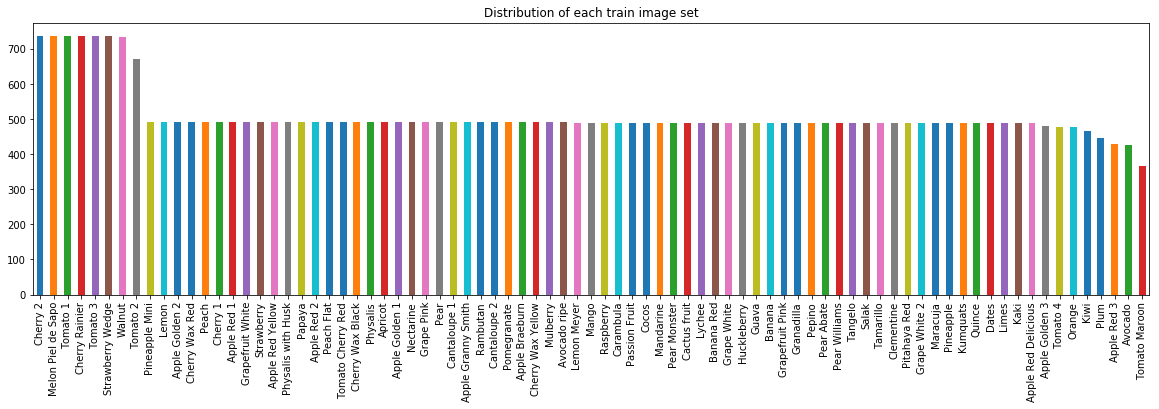

In [4]:
plt.figure(figsize=(20,5))
pd.value_counts(train_labels).plot.bar()
plt.title("Distribution of each train image set")
plt.show()

The training data is pretty evenly distributed with some some having slightly more and some having slightly more than the mean.

Looping through the test data using the same steps as the training data to create labels, and convert images into arrays.

In [5]:
test_image_names = []
test_labels = []
test_images = []

size = 100,100

for folder in test_folders:
    for file in os.listdir(os.path.join(test_data,folder)):
        if file.endswith("jpg"):
            test_image_names.append(os.path.join(test_data,folder,file))
            test_labels.append(folder)
            img = cv2.imread(os.path.join(test_data,folder,file))
            im = cv2.resize(img,size)
            test_images.append(im)
        else:
            continue


Visualize the distribution of the test image set

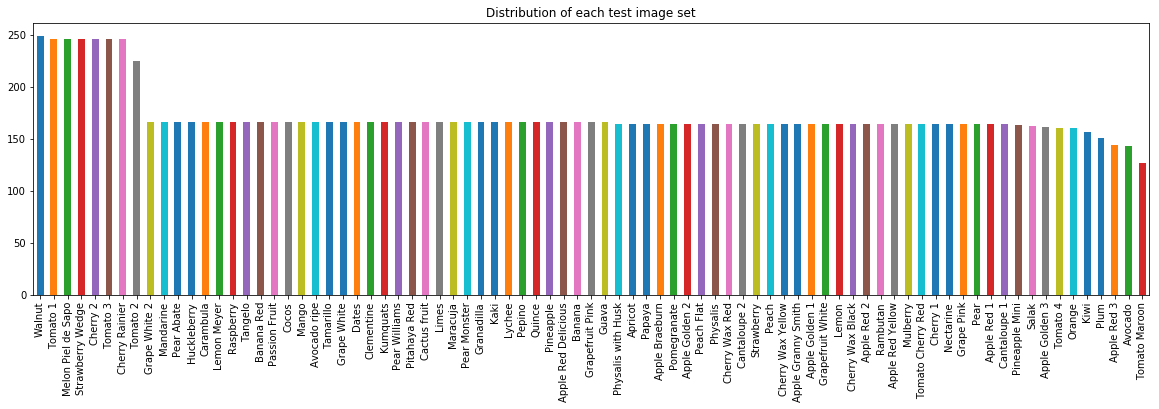

In [6]:
plt.figure(figsize=(20,5))
pd.value_counts(test_labels).plot.bar()
plt.title("Distribution of each test image set")
plt.show()

Great the test data distribution is the same as the training data.

Taking a look at some of the fruits that the neural networks will try to classify.

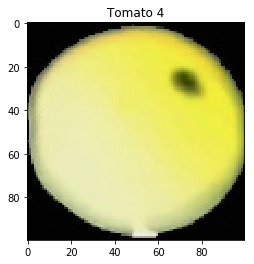

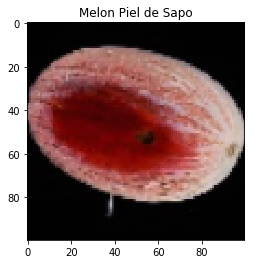

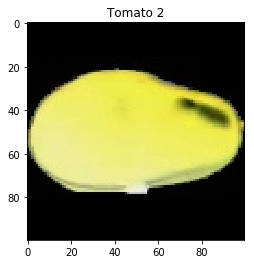

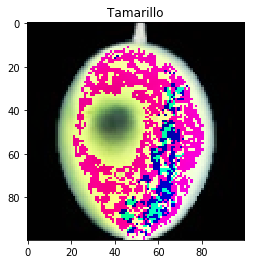

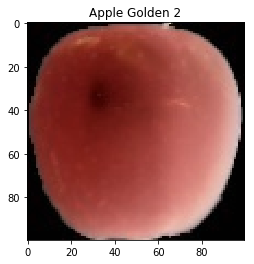

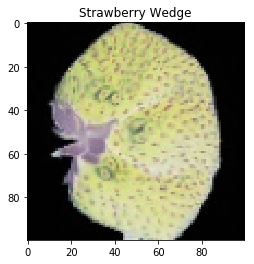

In [7]:
for fruit in [0, 2500, 5000, 7500, 10000, 12500]:
    image = train_images[fruit]
    image = np.array(image, dtype='float')
    pixels = image.reshape((100, 100, 3))
    plt.imshow(pixels)
    plt.title(train_labels[fruit])
    plt.show()

The images look good, and the data is ready to process further for model building. It is also important to note that OpenCV imports images as BGR instead of RGB, which is why the colors look different than expected.

First it is important to convert our training and test lists of arrays to an array of arrays. Normalization is also important so the mean is removed from each sample and divided by the standard deviation. 

In [8]:
X_train = np.array(train_images).astype('float32')
X_test = np.array(test_images).astype('float32')

X_train = (X_train - np.mean(X_train)) / np.std(X_train)
X_test = (X_test - np.mean(X_test)) / np.std(X_test)


Examining the shape of the data

In [9]:
print(X_train.shape)
print(X_test.shape)

(41322, 100, 100, 3)
(13877, 100, 100, 3)


The first number denotes the amount of samples, the next two number represent the dimensions, and the last number represents that it is an RGB value. So there are 41,322 training samples and 13,877 test samples that are 100 x 100 pixels and are RGB values.

The labels are currently in the form of strings, it is important to transform them to numeric values for classification. Sklearns preprocessing label encoder makes it a breeze.

In [10]:
from sklearn import preprocessing

# Label encoder
le = preprocessing.LabelEncoder()

le.fit(train_labels)

# Convert the author column to integers.
train_labels = le.transform(train_labels)

le.fit(test_labels)

# Convert the author column to integers.
test_labels = le.transform(test_labels)

# create a dictionary to show the old author names and the converted integer.
le_name_map = (dict(zip(le.classes_, le.transform(le.classes_))))

print(le_name_map)

{'Apple Braeburn': 0, 'Apple Golden 1': 1, 'Apple Golden 2': 2, 'Apple Golden 3': 3, 'Apple Granny Smith': 4, 'Apple Red 1': 5, 'Apple Red 2': 6, 'Apple Red 3': 7, 'Apple Red Delicious': 8, 'Apple Red Yellow': 9, 'Apricot': 10, 'Avocado': 11, 'Avocado ripe': 12, 'Banana': 13, 'Banana Red': 14, 'Cactus fruit': 15, 'Cantaloupe 1': 16, 'Cantaloupe 2': 17, 'Carambula': 18, 'Cherry 1': 19, 'Cherry 2': 20, 'Cherry Rainier': 21, 'Cherry Wax Black': 22, 'Cherry Wax Red': 23, 'Cherry Wax Yellow': 24, 'Clementine': 25, 'Cocos': 26, 'Dates': 27, 'Granadilla': 28, 'Grape Pink': 29, 'Grape White': 30, 'Grape White 2': 31, 'Grapefruit Pink': 32, 'Grapefruit White': 33, 'Guava': 34, 'Huckleberry': 35, 'Kaki': 36, 'Kiwi': 37, 'Kumquats': 38, 'Lemon': 39, 'Lemon Meyer': 40, 'Limes': 41, 'Lychee': 42, 'Mandarine': 43, 'Mango': 44, 'Maracuja': 45, 'Melon Piel de Sapo': 46, 'Mulberry': 47, 'Nectarine': 48, 'Orange': 49, 'Papaya': 50, 'Passion Fruit': 51, 'Peach': 52, 'Peach Flat': 53, 'Pear': 54, 'Pear Ab

There are 81 unique class values and they have all been successfully relabeled from 0-80.

Convert class vectors to binary class matrices So instead of one column with 81 values, create 81 binary columns with keras to categorical method.

In [11]:
y_train = keras.utils.to_categorical(train_labels, 81)
y_test = keras.utils.to_categorical(test_labels, 81)

The first neural network that will be built in an attempt to correctly classify the various fruits is a feed forward network using multiple dense layers with units doubling each layers, and dropout increasing incrementally as well. The dense layers will use the RELU activation function, and the out come will use a softmax activation. The model will be compiled with a categorical crossentropy loss function and Root mean squared prop for the optimizer. The metric that will be watched is Accuracy.

In [12]:
# Start with a simple sequential model
model = Sequential([keras.layers.Flatten(input_shape=(100, 100,3))])

# Add dense layers to create a fully connected MLP
# Relu is the activation function used
model.add(Dense(32, activation='relu'))
# Dropout layers remove features and fight overfitting
model.add(Dropout(0.1))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.50))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.75))

# End with a number of units equal to the number of classes we have for our outcome
model.add(Dense(81, activation='softmax'))

model.summary()

# Compile the model to put it all together.
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 30000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                960032    
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                2112      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               8320      
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
__________

The model compiled well and there is over one million trainable parameters

Time to evaluate the model. A batch size of 128 will be taken and ran with 10 epochs.

In [13]:
history = model.fit(X_train, y_train,
                    batch_size=128,
                    epochs=10,
                    verbose=1,
                    validation_data=(X_test, y_test))
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 41322 samples, validate on 13877 samples
Epoch 1/10
41322/41322 [==============================] - 51s 1ms/step - loss: 4.5075 - acc: 0.0172 - val_loss: 4.3867 - val_acc: 0.0177
Epoch 2/10
41322/41322 [==============================] - 30s 737us/step - loss: 4.3875 - acc: 0.0165 - val_loss: 4.3855 - val_acc: 0.0177
Epoch 3/10
41322/41322 [==============================] - 29s 698us/step - loss: 4.3867 - acc: 0.0182 - val_loss: 4.3852 - val_acc: 0.0177
Epoch 4/10
41322/41322 [==============================] - 30s 718us/step - loss: 4.3861 - acc: 0.0173 - val_loss: 4.3852 - val_acc: 0.0177
Epoch 5/10
41322/41322 [==============================] - 30s 729us/step - loss: 4.3858 - acc: 0.0170 - val_loss: 4.3852 - val_acc: 0.0177
Epoch 6/10
41322/41322 [==============================] - 29s 708us/step - loss: 4.3859 - acc: 0.0180 - val_loss: 4.3852 - val_acc: 0.0177
Epoch 7/10
41322/41322 [==============================] - 31s 742us/step - loss: 4.3859 - acc: 0.0188 - val_loss: 4.38

It looks like the only good thing about this model was that it was done relatively quickly for an artificial neural network averaging about 28 or 29 seconds per epoch. How does the accuracy and loss look?

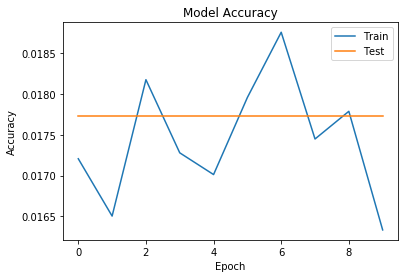

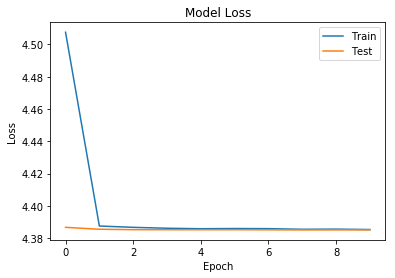

In [14]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

The model basically did nothing. During training the accuracy was all over the place and the test accuracy was rather stagnant. The loss barely dropped during training and stayed the same throughout testing.

The next model will again feature multiple dense layers starting from 32, and doubling until 256, and then reversing the process back to 32 with a dropout of .1. The same activation, loss, and optimizer functions will be used.

In [15]:
# Start with a simple sequential model
model = Sequential([keras.layers.Flatten(input_shape=(100, 100,3))])

# Add dense layers to create a fully connected MLP
# Relu is the activation function used
model.add(Dense(32, activation='relu'))
# Dropout layers remove features and fight overfitting
model.add(Dropout(0.1))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.1))
# End with a number of units equal to the number of classes we have for our outcome
model.add(Dense(81, activation='softmax'))

model.summary()

# Compile the model to put it all together.
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 30000)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 32)                960032    
_________________________________________________________________
dropout_5 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                2112      
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               8320      
_________________________________________________________________
dropout_7 (Dropout)          (None, 128)               0         
__________

There are slightly more trainable parameters this time around.

In [16]:
history = model.fit(X_train, y_train,
                    batch_size=128,
                    epochs=10,
                    verbose=1,
                    validation_data=(X_test, y_test))
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 41322 samples, validate on 13877 samples
Epoch 1/10
41322/41322 [==============================] - 34s 826us/step - loss: 3.8002 - acc: 0.0729 - val_loss: 2.8028 - val_acc: 0.2028
Epoch 2/10
41322/41322 [==============================] - 32s 769us/step - loss: 2.7291 - acc: 0.2079 - val_loss: 2.0425 - val_acc: 0.3814
Epoch 3/10
41322/41322 [==============================] - 34s 827us/step - loss: 2.2927 - acc: 0.3039 - val_loss: 1.8243 - val_acc: 0.4342
Epoch 4/10
41322/41322 [==============================] - 34s 832us/step - loss: 2.0515 - acc: 0.3801 - val_loss: 1.5659 - val_acc: 0.5329
Epoch 5/10
41322/41322 [==============================] - 33s 796us/step - loss: 1.8489 - acc: 0.4379 - val_loss: 1.4017 - val_acc: 0.5647
Epoch 6/10
41322/41322 [==============================] - 33s 790us/step - loss: 1.6931 - acc: 0.4830 - val_loss: 1.4813 - val_acc: 0.5488
Epoch 7/10
41322/41322 [==============================] - 34s 827us/step - loss: 1.5606 - acc: 0.5297 - val_loss: 1.

This model performed much better predicting a test accuracy of 70% the accuracy and loss continued to increment in a positive direction, and it was only slightly slower than the previous model.

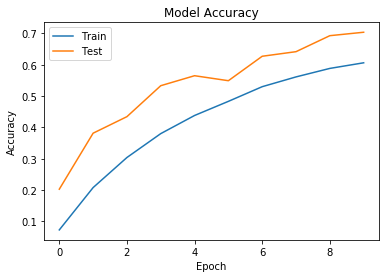

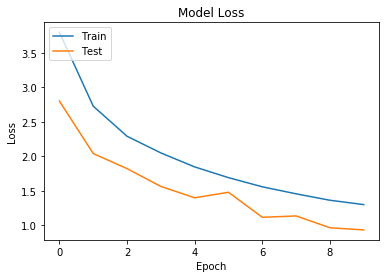

In [17]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

The accuracy looks good trending upward, a few more epochs might draw some more accuracy out of this model. The loss was dropping nicely as well. It is suprising and interesting to see that the test loss is actually lower than the training loss, and the test accuracy is higher than the training.

The next model will be slightly different using dense layers with the same amount of units and dropout.

In [18]:
# Start with a simple sequential model
model = Sequential([keras.layers.Flatten(input_shape=(100, 100,3))])

# Add dense layers to create a fully connected MLP
# Relu is the activation function used
model.add(Dense(56, activation='relu'))
# Dropout layers remove features and fight overfitting
model.add(Dropout(0.1))
model.add(Dense(56, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(56, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(56, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(56, activation='relu'))
model.add(Dropout(0.1))

# End with a number of units equal to the number of classes we have for our outcome
model.add(Dense(81, activation='softmax'))

model.summary()

# Compile the model to put it all together.
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 30000)             0         
_________________________________________________________________
dense_15 (Dense)             (None, 56)                1680056   
_________________________________________________________________
dropout_13 (Dropout)         (None, 56)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 56)                3192      
_________________________________________________________________
dropout_14 (Dropout)         (None, 56)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 56)                3192      
_________________________________________________________________
dropout_15 (Dropout)         (None, 56)                0         
__________

There are a lot more trainable parameters here with nearly 1.7 million.

In [19]:
history = model.fit(X_train, y_train,
                    batch_size=128,
                    epochs=10,
                    verbose=1,
                    validation_data=(X_test, y_test))
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 41322 samples, validate on 13877 samples
Epoch 1/10
41322/41322 [==============================] - 36s 869us/step - loss: 3.7252 - acc: 0.0930 - val_loss: 2.9084 - val_acc: 0.2194
Epoch 2/10
41322/41322 [==============================] - 33s 801us/step - loss: 2.8412 - acc: 0.1984 - val_loss: 2.1698 - val_acc: 0.3677
Epoch 3/10
41322/41322 [==============================] - 34s 830us/step - loss: 2.3192 - acc: 0.3099 - val_loss: 1.8012 - val_acc: 0.4924
Epoch 4/10
41322/41322 [==============================] - 37s 886us/step - loss: 2.0347 - acc: 0.3823 - val_loss: 1.4942 - val_acc: 0.5544
Epoch 5/10
41322/41322 [==============================] - 34s 823us/step - loss: 1.8416 - acc: 0.4433 - val_loss: 1.5043 - val_acc: 0.5113
Epoch 6/10
41322/41322 [==============================] - 37s 885us/step - loss: 1.6913 - acc: 0.4900 - val_loss: 1.2392 - val_acc: 0.6223
Epoch 7/10
41322/41322 [==============================] - 35s 843us/step - loss: 1.5784 - acc: 0.5233 - val_loss: 1.

This model did ok with a test accuracy of 67%, and again slightly slower than the previous models. One or two more epochs might increase it slightly.

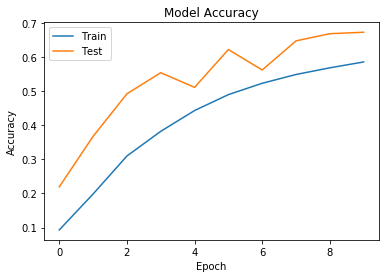

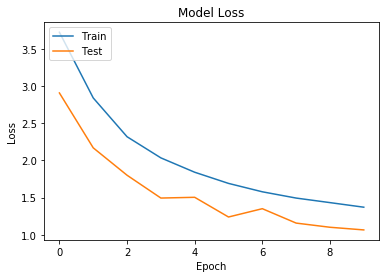

In [20]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

The accuracy was jumping up nicely, towards the middle it started to get a little more rocky and stopped gaining in elevation, leading me to believe any more epochs would be a waste. The loss dropped nicely at first, and slowed about halfway through. It is interesting again to see that the training and test accuracy and loss visualizations are inverse to what would be expected.

This time there will be more layers and more units per layer with the same .1 dropout, and all of the same functions used previously.

In [21]:
# Start with a simple sequential model
model = Sequential([keras.layers.Flatten(input_shape=(100, 100,3))])

# Add dense layers to create a fully connected MLP
# Relu is the activation function used
model.add(Dense(128, activation='relu'))
# Dropout layers remove features and fight overfitting
model.add(Dropout(0.1))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.1))
# End with a number of units equal to the number of classes we have for our outcome
model.add(Dense(81, activation='softmax'))

model.summary()

# Compile the model to put it all together.
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 30000)             0         
_________________________________________________________________
dense_21 (Dense)             (None, 128)               3840128   
_________________________________________________________________
dropout_18 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_19 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_20 (Dropout)         (None, 128)               0         
__________

There are a whopping four millions trainable parameters.

In [22]:
history = model.fit(X_train, y_train,
                    batch_size=128,
                    epochs=10,
                    verbose=1,
                    validation_data=(X_test, y_test))
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 41322 samples, validate on 13877 samples
Epoch 1/10
41322/41322 [==============================] - 55s 1ms/step - loss: 3.0663 - acc: 0.1673 - val_loss: 1.5620 - val_acc: 0.5025
Epoch 2/10
41322/41322 [==============================] - 52s 1ms/step - loss: 1.6156 - acc: 0.4719 - val_loss: 1.0049 - val_acc: 0.6861
Epoch 3/10
41322/41322 [==============================] - 49s 1ms/step - loss: 1.0800 - acc: 0.6425 - val_loss: 0.7411 - val_acc: 0.7769
Epoch 4/10
41322/41322 [==============================] - 48s 1ms/step - loss: 0.8180 - acc: 0.7372 - val_loss: 0.7693 - val_acc: 0.7837
Epoch 5/10
41322/41322 [==============================] - 50s 1ms/step - loss: 0.6628 - acc: 0.7931 - val_loss: 0.7699 - val_acc: 0.7919
Epoch 6/10
41322/41322 [==============================] - 47s 1ms/step - loss: 0.5654 - acc: 0.8272 - val_loss: 0.7485 - val_acc: 0.8115
Epoch 7/10
41322/41322 [==============================] - 50s 1ms/step - loss: 0.4908 - acc: 0.8562 - val_loss: 0.4155 - val_acc

This model was much slower than the previous models, but the accuracy made it worth it with an 89% accuracy rate, and no overfitting. 7 or 8 epochs would have been enough.

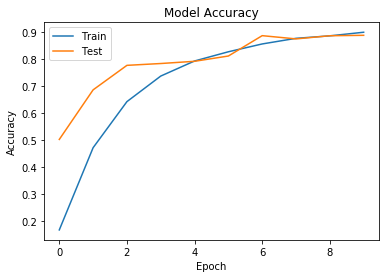

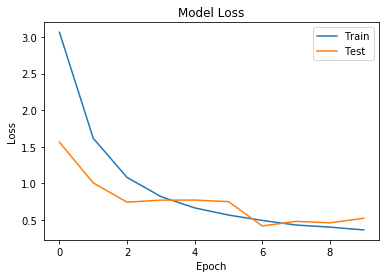

In [23]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

The graph looks great with the training and test accuracy staying pretty close to each other. Same with the loss. It looks like at about 6 or 7 it starts to want to over fit a bit.

To visualize overfitting 10 more epochs will be ran.

In [24]:
history = model.fit(X_train, y_train,
                    batch_size=128,
                    epochs=10,
                    verbose=1,
                    validation_data=(X_test, y_test))
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 41322 samples, validate on 13877 samples
Epoch 1/10
41322/41322 [==============================] - 48s 1ms/step - loss: 0.3388 - acc: 0.9048 - val_loss: 0.5390 - val_acc: 0.8842
Epoch 2/10
41322/41322 [==============================] - 48s 1ms/step - loss: 0.3177 - acc: 0.9123 - val_loss: 0.4695 - val_acc: 0.8866
Epoch 3/10
41322/41322 [==============================] - 47s 1ms/step - loss: 0.2985 - acc: 0.9190 - val_loss: 0.4115 - val_acc: 0.9008
Epoch 4/10
41322/41322 [==============================] - 46s 1ms/step - loss: 0.2936 - acc: 0.9227 - val_loss: 0.5515 - val_acc: 0.8763
Epoch 5/10
41322/41322 [==============================] - 47s 1ms/step - loss: 0.2841 - acc: 0.9264 - val_loss: 0.5728 - val_acc: 0.8678
Epoch 6/10
41322/41322 [==============================] - 47s 1ms/step - loss: 0.2733 - acc: 0.9300 - val_loss: 0.4277 - val_acc: 0.9061
Epoch 7/10
41322/41322 [==============================] - 46s 1ms/step - loss: 0.2745 - acc: 0.9296 - val_loss: 0.6213 - val_acc

The accuracy did actually go up slightly, but the gap between training and test accuracy grew quite a bit indicating overfitting.

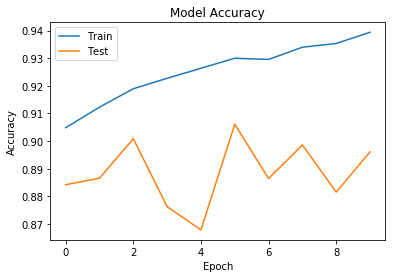

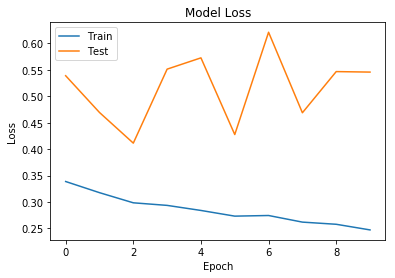

In [25]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

Both of the graphs are horrible with a ton of overfitting happening.

A convolutional neural network will be used to test its performance against the previous feed forward networks. It will start with 32 units doubling until 128, with incrementing dropout. The same functions will be used except adadelta will be used instead of rmsprop.

In [26]:
img_rows, img_cols = 100, 100
num_classes = 81

if K.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 3, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 3, img_rows, img_cols)
    input_shape = (3, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 3)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 3)
    input_shape = (img_rows, img_cols, 3)

# Building the Model
model = Sequential()
# First convolutional layer, note the specification of shape
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit(X_train, y_train,
          batch_size=128,
          epochs=10,
          verbose=1,
          validation_data=(X_test, y_test))
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 41322 samples, validate on 13877 samples
Epoch 1/10
41322/41322 [==============================] - 1906s 46ms/step - loss: 1.3193 - acc: 0.6704 - val_loss: 0.3140 - val_acc: 0.9039
Epoch 2/10
41322/41322 [==============================] - 1935s 47ms/step - loss: 0.1869 - acc: 0.9381 - val_loss: 0.2222 - val_acc: 0.9338
Epoch 3/10
41322/41322 [==============================] - 2170s 53ms/step - loss: 0.1042 - acc: 0.9644 - val_loss: 0.1739 - val_acc: 0.9462
Epoch 4/10
41322/41322 [==============================] - 2110s 51ms/step - loss: 0.0766 - acc: 0.9724 - val_loss: 0.2412 - val_acc: 0.9388
Epoch 5/10
41322/41322 [==============================] - 1990s 48ms/step - loss: 0.0623 - acc: 0.9773 - val_loss: 0.2282 - val_acc: 0.9457
Epoch 6/10
41322/41322 [==============================] - 1879s 45ms/step - loss: 0.0551 - acc: 0.9799 - val_loss: 0.1934 - val_acc: 0.9522
Epoch 7/10
41322/41322 [==============================] - 1859s 45ms/step - loss: 0.0506 - acc: 0.9809 - val_l

The cnn performed well with the highest accuracy yet at 95%, it did however take nearly 6 hours to run. It also overfitted a little. 6 epochs would have been enough here.

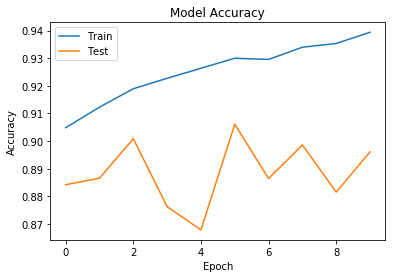

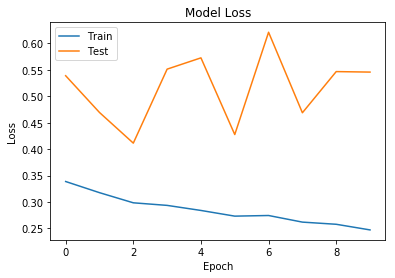

In [27]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

You can really tell in the loss function here that 6 epochs would have been the ideal amount to use.

## Conclusion
The first model didn't fair to well it appears like the dropout was just to severe for it to learn anything meaningful. The network actually seemed to know less after attempting than before.

The second model worked fairly decent, with the lower dropout playing a bigger role.

The third model was comparable to the second model even though it was switched up quite a bit using the same amount of units per dense layer. The 10% dropout did quite well and didn't have much overfitting.

The fourth model did very well classifying 89% of the data accurately. It didn't have any overfitting going on and performed relatively quickly. After attempting to run the model a few more epochs it just caused overfitting.

Finally the convolutional neural network performed very well with an accuracy of 95%. On the downside the convolutional neural network took a very long time to run, but they really are ideal for image based datasets.

The CNN proved to be a powerhouse, however with some further experimentation a feed forward network could possibly be created to outperform this rendition of the CNN, and do it faster. Neural networks are very powerful and also quite computer intensive. They are extremely flexible, and there are so many different ways to set them up that there is a set up for nearly every problem that can possibly need to be solved.